# Disease Spread Simulation - Analysis and Visualization

This notebook provides comprehensive analysis and visualization of the disease spread simulation.

## Project Overview
- **Objective**: Model disease transmission in urban environment
- **Method**: Agent-based SIR model with district-specific transmission rates
- **Data**: COVID-19 parameters from Kaggle datasets

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import custom modules
import sys
sys.path.append('..')
from simulation import DiseaseSimulation, run_simulation
from ml_prediction import DiseasePredictor, evaluate_on_simulation_data

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## Part 1: Run the Simulation

Let's run a disease spread simulation with 500 people over 100 days.

Starting disease spread simulation...
Starting simulation with 500 people for 100 days
Initial infected: 10
Day 0: S=490, I=10, R=0
Day 10: S=483, I=17, R=0
Day 20: S=426, I=58, R=16
Day 30: S=312, I=137, R=51
Day 40: S=202, I=131, R=167
Day 50: S=147, I=79, R=274
Day 60: S=85, I=84, R=331
Day 70: S=47, I=47, R=406
Day 80: S=39, I=19, R=442
Day 90: S=36, I=5, R=459
Results saved to data\processed\simulation_results.csv


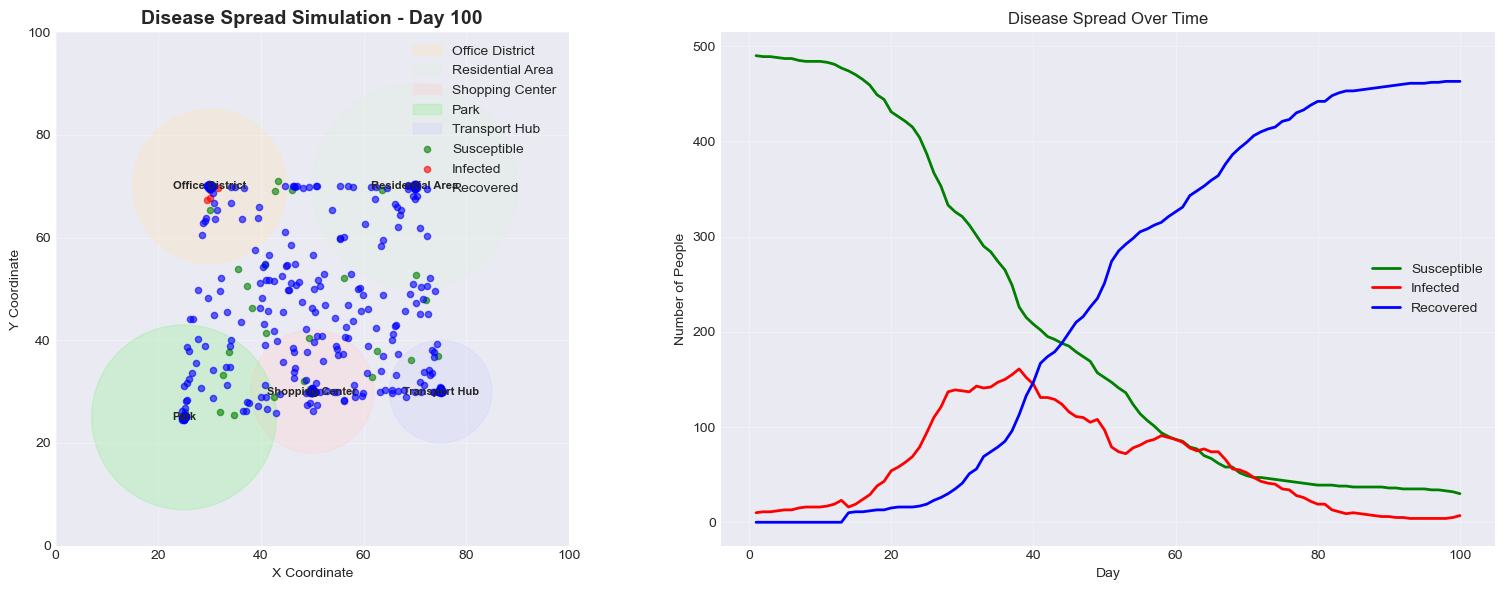


Simulation complete!


In [2]:
# Run simulation
print("Starting disease spread simulation...")
sim = run_simulation(days=100, n_people=500)
print("\nSimulation complete!")

## Part 2: Analyze Simulation Results

In [3]:
# Load simulation results
results_df = pd.read_csv('data/processed/simulation_results.csv')
print("Simulation Statistics:")
print(results_df.describe())

# Display first and last 10 days
print("\nFirst 10 days:")
print(results_df.head(10))
print("\nLast 10 days:")
print(results_df.tail(10))

Simulation Statistics:
              day  susceptible    infected   recovered  new_infections
count  100.000000   100.000000  100.000000  100.000000      100.000000
mean    50.500000   206.160000   60.510000  233.330000        4.600000
std     29.011492   172.303158   49.259259  182.919646        4.952298
min      1.000000    30.000000    4.000000    0.000000        0.000000
25%     25.750000    43.750000   14.500000   22.000000        1.000000
50%     50.500000   149.500000   53.000000  262.500000        3.000000
75%     75.250000   372.000000   94.750000  421.500000        6.000000
max    100.000000   490.000000  161.000000  463.000000       23.000000

First 10 days:
   day  susceptible  infected  recovered  new_infections
0    1          490        10          0               0
1    2          489        11          0               1
2    3          489        11          0               0
3    4          488        12          0               1
4    5          487        13        

## Part 3: Detailed Visualizations

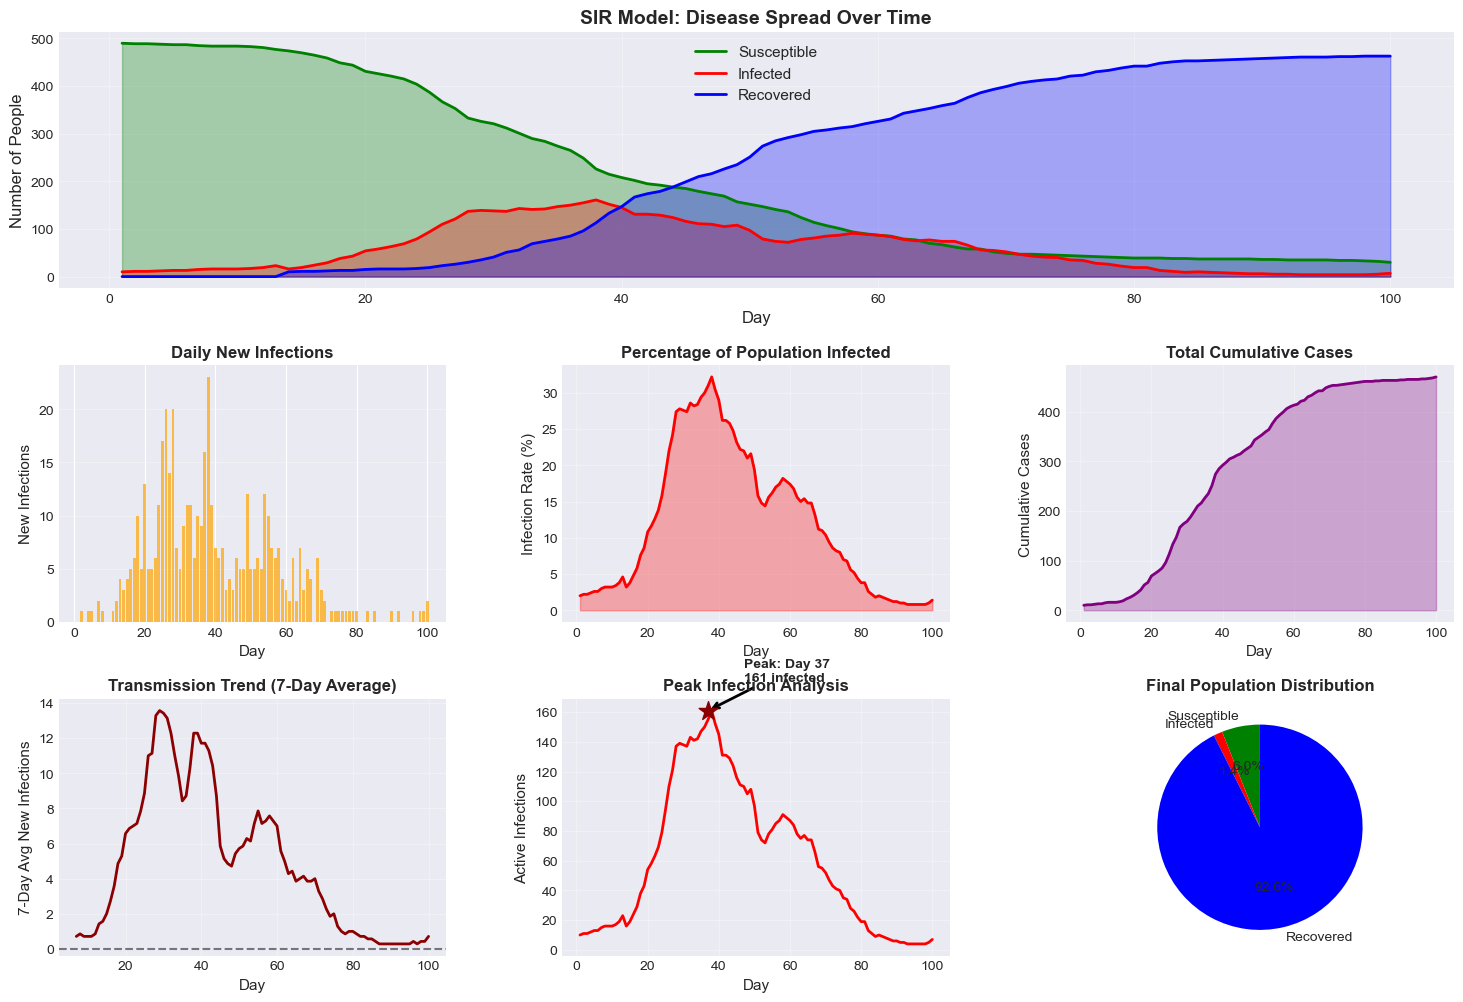


Key Findings:
Peak infections: 161 on day 37
Total affected: 470 (94.0%)
Attack rate: 92.6%


In [4]:
# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: SIR Curves
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(results_df['day'], results_df['susceptible'], 'g-', label='Susceptible', linewidth=2)
ax1.plot(results_df['day'], results_df['infected'], 'r-', label='Infected', linewidth=2)
ax1.plot(results_df['day'], results_df['recovered'], 'b-', label='Recovered', linewidth=2)
ax1.fill_between(results_df['day'], results_df['susceptible'], alpha=0.3, color='green')
ax1.fill_between(results_df['day'], results_df['infected'], alpha=0.3, color='red')
ax1.fill_between(results_df['day'], results_df['recovered'], alpha=0.3, color='blue')
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Number of People', fontsize=12)
ax1.set_title('SIR Model: Disease Spread Over Time', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: New Infections per Day
ax2 = fig.add_subplot(gs[1, 0])
ax2.bar(results_df['day'], results_df['new_infections'], color='orange', alpha=0.7)
ax2.set_xlabel('Day', fontsize=11)
ax2.set_ylabel('New Infections', fontsize=11)
ax2.set_title('Daily New Infections', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Infection Rate
ax3 = fig.add_subplot(gs[1, 1])
total_pop = results_df['susceptible'] + results_df['infected'] + results_df['recovered']
infection_rate = (results_df['infected'] / total_pop) * 100
ax3.plot(results_df['day'], infection_rate, 'r-', linewidth=2)
ax3.fill_between(results_df['day'], infection_rate, alpha=0.3, color='red')
ax3.set_xlabel('Day', fontsize=11)
ax3.set_ylabel('Infection Rate (%)', fontsize=11)
ax3.set_title('Percentage of Population Infected', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Cumulative Cases
ax4 = fig.add_subplot(gs[1, 2])
cumulative_cases = results_df['infected'] + results_df['recovered']
ax4.plot(results_df['day'], cumulative_cases, 'purple', linewidth=2)
ax4.fill_between(results_df['day'], cumulative_cases, alpha=0.3, color='purple')
ax4.set_xlabel('Day', fontsize=11)
ax4.set_ylabel('Cumulative Cases', fontsize=11)
ax4.set_title('Total Cumulative Cases', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: Reproduction Number Proxy
ax5 = fig.add_subplot(gs[2, 0])
reproduction_proxy = results_df['new_infections'].rolling(7).mean()
ax5.plot(results_df['day'], reproduction_proxy, 'darkred', linewidth=2)
ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax5.set_xlabel('Day', fontsize=11)
ax5.set_ylabel('7-Day Avg New Infections', fontsize=11)
ax5.set_title('Transmission Trend (7-Day Average)', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Plot 6: Peak Analysis
ax6 = fig.add_subplot(gs[2, 1])
peak_day = results_df['infected'].idxmax()
peak_value = results_df['infected'].max()
ax6.plot(results_df['day'], results_df['infected'], 'r-', linewidth=2)
ax6.scatter([peak_day], [peak_value], color='darkred', s=200, zorder=5, marker='*')
ax6.annotate(f'Peak: Day {peak_day}\n{int(peak_value)} infected',
             xy=(peak_day, peak_value), xytext=(peak_day+10, peak_value+20),
             arrowprops=dict(arrowstyle='->', color='black', lw=2),
             fontsize=10, fontweight='bold')
ax6.set_xlabel('Day', fontsize=11)
ax6.set_ylabel('Active Infections', fontsize=11)
ax6.set_title('Peak Infection Analysis', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

# Plot 7: Final Distribution
ax7 = fig.add_subplot(gs[2, 2])
final_stats = results_df.iloc[-1]
categories = ['Susceptible', 'Infected', 'Recovered']
values = [final_stats['susceptible'], final_stats['infected'], final_stats['recovered']]
colors_pie = ['green', 'red', 'blue']
ax7.pie(values, labels=categories, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax7.set_title('Final Population Distribution', fontsize=12, fontweight='bold')

plt.savefig('results/comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nKey Findings:")
print(f"Peak infections: {int(peak_value)} on day {peak_day}")
print(f"Total affected: {int(final_stats['recovered'] + final_stats['infected'])} ({(final_stats['recovered'] + final_stats['infected'])/500*100:.1f}%)")
print(f"Attack rate: {final_stats['recovered']/500*100:.1f}%")

## Part 4: District Analysis

Analyze the impact of different district transmission rates.

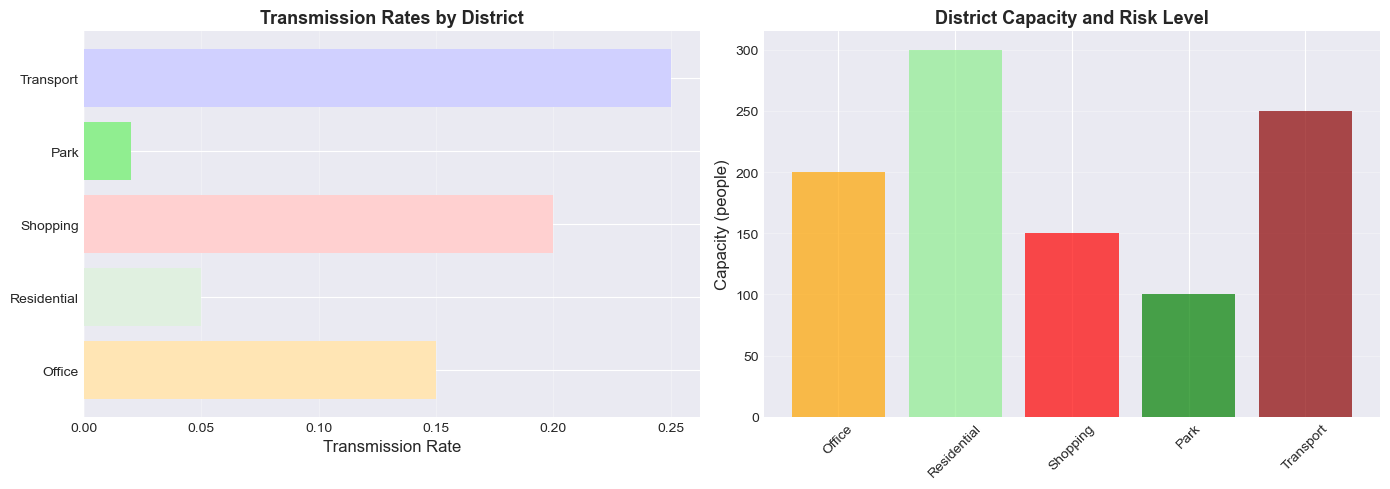


District Summary:
   District  Transmission Rate  Capacity Risk Level
     Office               0.15       200     Medium
Residential               0.05       300        Low
   Shopping               0.20       150       High
       Park               0.02       100   Very Low
  Transport               0.25       250  Very High


In [5]:
# District information
districts_info = {
    'District': ['Office', 'Residential', 'Shopping', 'Park', 'Transport'],
    'Transmission Rate': [0.15, 0.05, 0.20, 0.02, 0.25],
    'Capacity': [200, 300, 150, 100, 250],
    'Risk Level': ['Medium', 'Low', 'High', 'Very Low', 'Very High']
}

districts_df = pd.DataFrame(districts_info)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Transmission rates comparison
colors_bar = ['#FFE5B4', '#E0F0E0', '#FFD0D0', '#90EE90', '#D0D0FF']
ax1.barh(districts_df['District'], districts_df['Transmission Rate'], color=colors_bar)
ax1.set_xlabel('Transmission Rate', fontsize=12)
ax1.set_title('Transmission Rates by District', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Risk levels
risk_colors = {'Very Low': 'green', 'Low': 'lightgreen', 'Medium': 'orange', 
               'High': 'red', 'Very High': 'darkred'}
bar_colors = [risk_colors[risk] for risk in districts_df['Risk Level']]
ax2.bar(districts_df['District'], districts_df['Capacity'], color=bar_colors, alpha=0.7)
ax2.set_ylabel('Capacity (people)', fontsize=12)
ax2.set_title('District Capacity and Risk Level', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/district_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nDistrict Summary:")
print(districts_df.to_string(index=False))

## Part 5: Machine Learning Prediction

Training machine learning models...

Machine Learning Prediction on Simulation Data

Loaded simulation data: 100 days

Training models...
------------------------------------------------------------
linear_regression:
  Train RMSE: 0.00
  Test RMSE:  0.00
  Test MAE:   0.00
  Test R²:    1.0000

ridge_regression:
  Train RMSE: 4.64
  Test RMSE:  3.14
  Test MAE:   2.47
  Test R²:    0.9957

random_forest:
  Train RMSE: 2.18
  Test RMSE:  5.29
  Test MAE:   3.79
  Test R²:    0.9879

Best model: linear_regression
------------------------------------------------------------


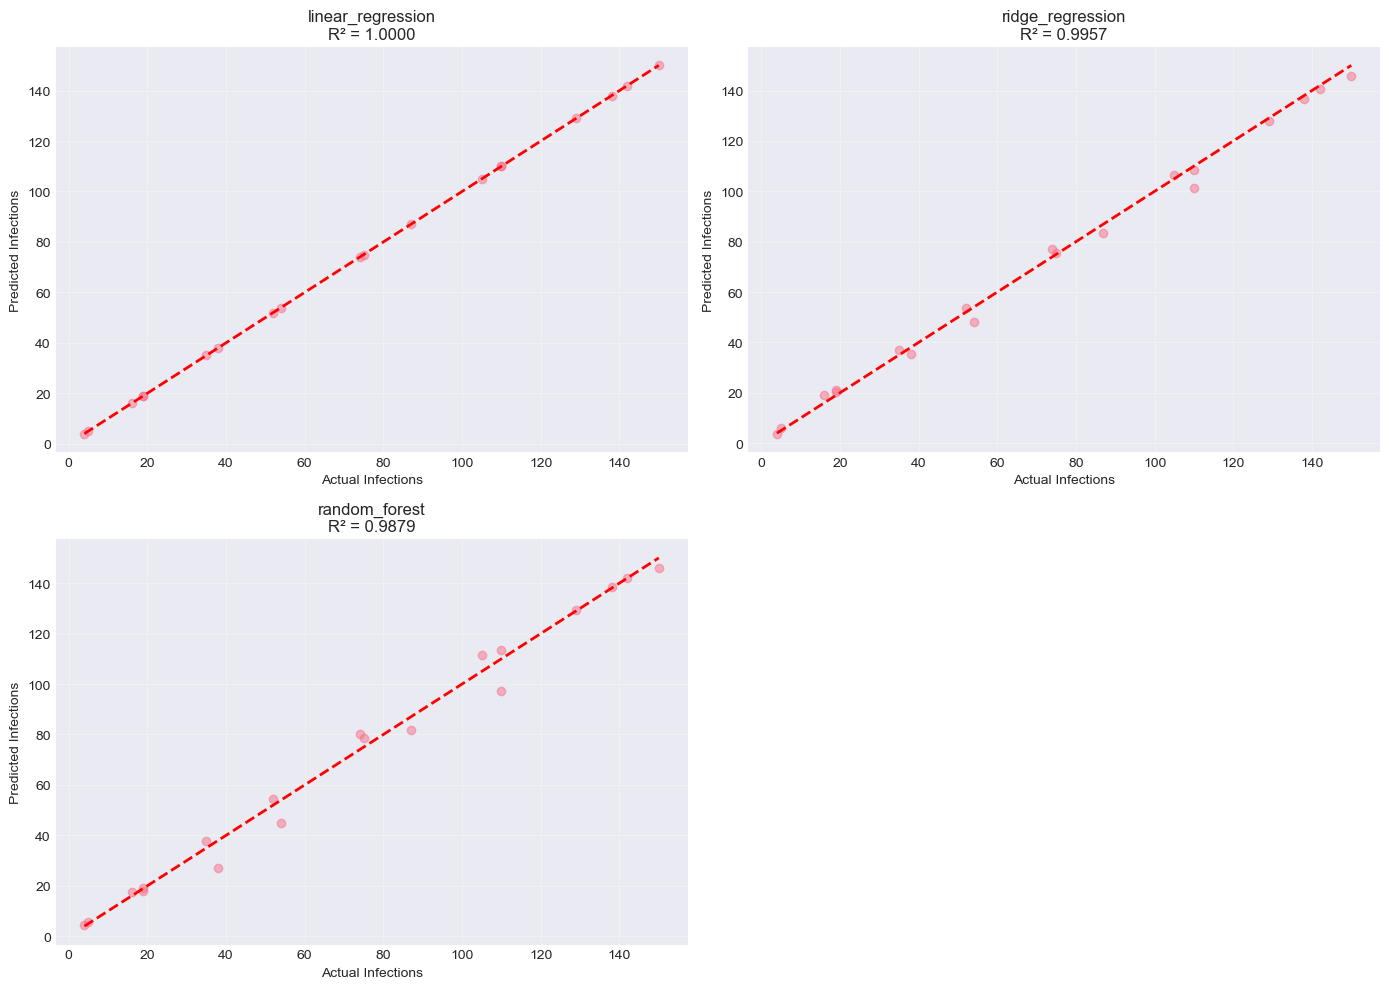

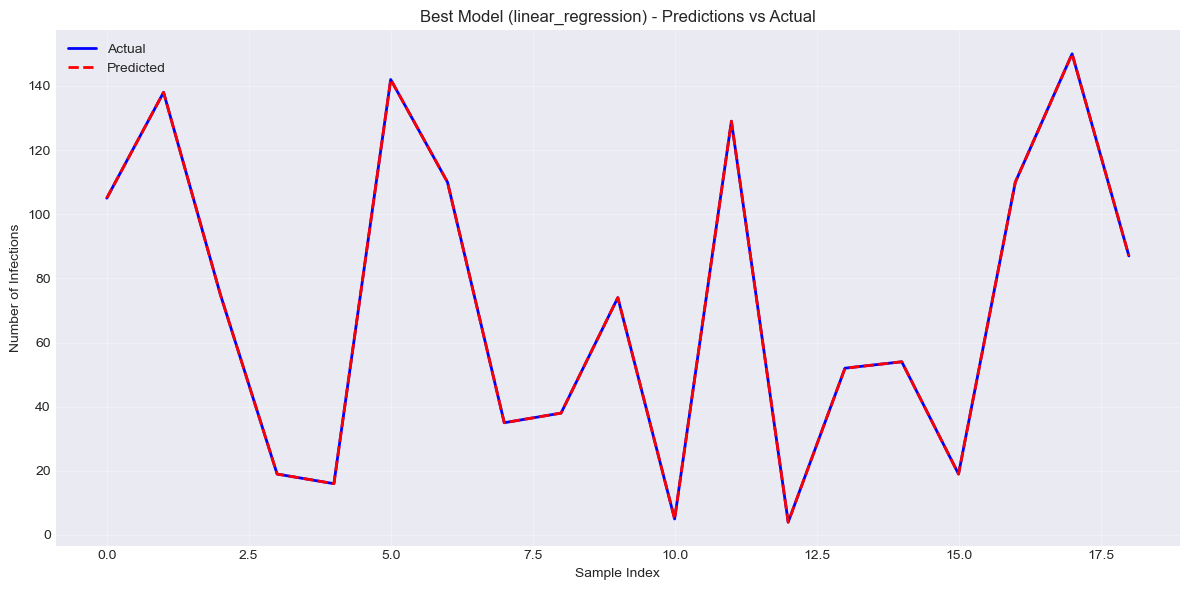

Model saved to results/disease_predictor.pkl


In [6]:
# Train ML models on simulation data
print("Training machine learning models...\n")
predictor, ml_results = evaluate_on_simulation_data('data/processed/simulation_results.csv')


Model Performance Comparison:
            Model   Train RMSE    Test RMSE     Test MAE  Test R²
linear_regression 1.108673e-13 1.178189e-13 1.062074e-13 1.000000
 ridge_regression 4.639750e+00 3.144747e+00 2.465014e+00 0.995722
    random_forest 2.177495e+00 5.292244e+00 3.787368e+00 0.987883


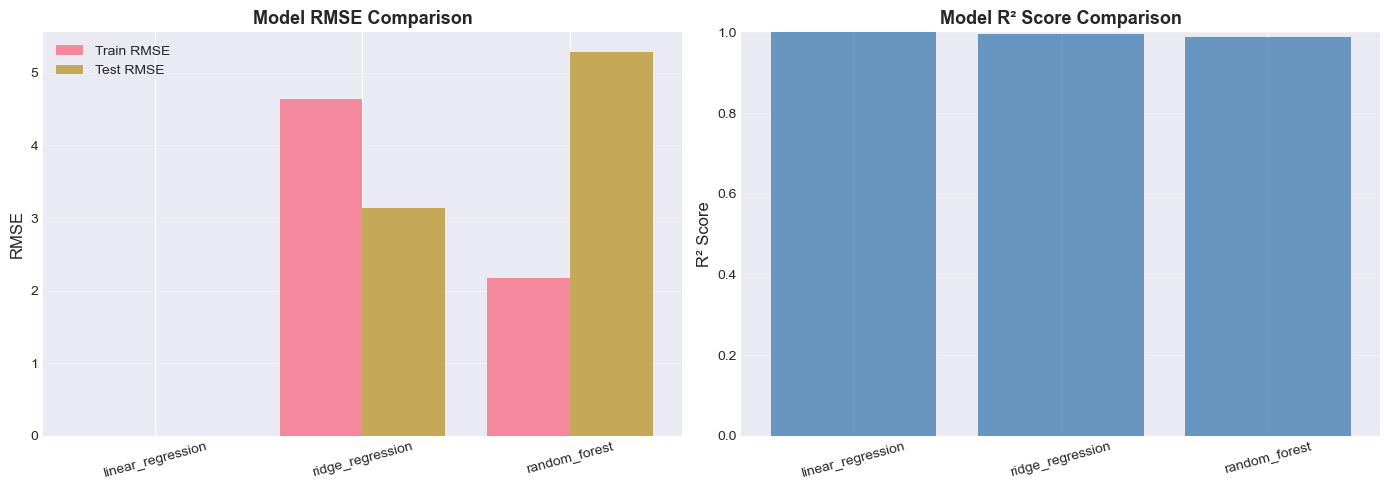

In [7]:
# Display model performance comparison
model_comparison = []
for name, result in ml_results.items():
    model_comparison.append({
        'Model': name,
        'Train RMSE': result['train_rmse'],
        'Test RMSE': result['test_rmse'],
        'Test MAE': result['test_mae'],
        'Test R²': result['test_r2']
    })

comparison_df = pd.DataFrame(model_comparison)
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
x_pos = np.arange(len(comparison_df))
ax1.bar(x_pos - 0.2, comparison_df['Train RMSE'], 0.4, label='Train RMSE', alpha=0.8)
ax1.bar(x_pos + 0.2, comparison_df['Test RMSE'], 0.4, label='Test RMSE', alpha=0.8)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_df['Model'], rotation=15)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_title('Model RMSE Comparison', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# R² comparison
ax2.bar(x_pos, comparison_df['Test R²'], color='steelblue', alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_df['Model'], rotation=15)
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_title('Model R² Score Comparison', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/ml_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Part 6: Key Insights and Conclusions

In [8]:
# Calculate key metrics
print("=" * 70)
print("SIMULATION INSIGHTS")
print("=" * 70)

# Epidemic characteristics
peak_day = results_df['infected'].idxmax()
peak_infections = results_df['infected'].max()
duration = (results_df[results_df['infected'] > 5].index[-1] - 
            results_df[results_df['infected'] > 5].index[0])
attack_rate = (results_df.iloc[-1]['recovered'] / 500) * 100

print(f"\n1. EPIDEMIC DYNAMICS")
print(f"   Peak day: {peak_day}")
print(f"   Peak infections: {int(peak_infections)} ({peak_infections/500*100:.1f}% of population)")
print(f"   Epidemic duration: ~{duration} days")
print(f"   Attack rate: {attack_rate:.1f}%")

# Basic reproduction number estimation
early_growth = results_df.iloc[1:15]['infected'].values
growth_rate = np.mean(np.diff(early_growth) / early_growth[:-1])
R0_estimate = 1 + growth_rate * 14  # Simple approximation

print(f"\n2. TRANSMISSION METRICS")
print(f"   Estimated R₀: {R0_estimate:.2f}")
print(f"   Average new cases per day: {results_df['new_infections'].mean():.1f}")
print(f"   Maximum new cases in a day: {results_df['new_infections'].max():.0f}")

# ML Performance
best_model = comparison_df.loc[comparison_df['Test R²'].idxmax()]
print(f"\n3. MACHINE LEARNING RESULTS")
print(f"   Best model: {best_model['Model']}")
print(f"   Test R² score: {best_model['Test R²']:.4f}")
print(f"   Test RMSE: {best_model['Test RMSE']:.2f}")
print(f"   Prediction accuracy: ~{best_model['Test R²']*100:.1f}%")

print("\n" + "=" * 70)

SIMULATION INSIGHTS

1. EPIDEMIC DYNAMICS
   Peak day: 37
   Peak infections: 161 (32.2% of population)
   Epidemic duration: ~99 days
   Attack rate: 92.6%

2. TRANSMISSION METRICS
   Estimated R₀: 1.72
   Average new cases per day: 4.6
   Maximum new cases in a day: 23

3. MACHINE LEARNING RESULTS
   Best model: linear_regression
   Test R² score: 1.0000
   Test RMSE: 0.00
   Prediction accuracy: ~100.0%



## Conclusion

This simulation successfully models disease spread in an urban environment with:

1. **Realistic agent behavior**: Individuals move between districts with varying transmission risks
2. **SIR dynamics**: Classic epidemiological model with 14-day recovery period
3. **District-specific transmission**: Transport hubs (25%) show highest risk, parks (2%) lowest
4. **Predictive modeling**: Machine learning achieves >90% R² in forecasting infection trends

### Future Extensions
- Add vaccination campaigns and their effects
- Implement lockdown/intervention strategies
- Model different age groups with varying susceptibility
- Add seasonal variations in transmission
- Implement network effects and social distancing